# Example usage

In [1]:
import sys
sys.path.append('..')

## Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [3]:
data_df = pd.read_csv('../data/products.csv', sep=';')
data_df.head()

,category,subcategory,name
0,Канцтовары,Бумажная продукция,"Скетчбук А5, блокнот для скетчинга"
1,Канцтовары,Бумажная продукция,Блокнот
2,Канцтовары,Бумажная продукция,"для принтера, 2500"
3,Канцтовары,Бумажная продукция,Бумага а4 для принтера оргтехники
4,Канцтовары,Бумажная продукция,Бумага а4 для принтера оргтехники


In [4]:
data_df['tag'] = data_df['name'].apply(lambda x: re.sub('[^a-zа-я0-9 ]', '', x.lower()).split(' '))
data_df.head()

,category,subcategory,name,tag
0,Канцтовары,Бумажная продукция,"Скетчбук А5, блокнот для скетчинга","[скетчбук, а5, блокнот, для, скетчинга]"
1,Канцтовары,Бумажная продукция,Блокнот,[блокнот]
2,Канцтовары,Бумажная продукция,"для принтера, 2500","[для, принтера, 2500]"
3,Канцтовары,Бумажная продукция,Бумага а4 для принтера оргтехники,"[бумага, а4, для, принтера, оргтехники]"
4,Канцтовары,Бумажная продукция,Бумага а4 для принтера оргтехники,"[бумага, а4, для, принтера, оргтехники]"


In [5]:
category_x_tag_df = data_df.explode('tag', ignore_index=True)[['category', 'tag']]
category_x_tag_df = category_x_tag_df.loc[category_x_tag_df['tag'].apply(len) > 2]
category_x_tag_df.head()

,category,tag
0,Канцтовары,скетчбук
2,Канцтовары,блокнот
3,Канцтовары,для
4,Канцтовары,скетчинга
5,Канцтовары,блокнот


In [6]:
tf = (category_x_tag_df.groupby(
    by=['category', 'tag']
).size().to_frame('tf') / category_x_tag_df.groupby(
    by=['category']
).size().to_frame('tf')).reset_index()

tf = tf.join(
    other=(category_x_tag_df.category.nunique() / category_x_tag_df.groupby(by=['tag']).category.nunique()).apply(np.log).rename('idf'),
    how='left',
    on='tag',
)

tf.head()

,category,tag,tf,idf
0,Автотовары,000107306p,0.000135,2.995732
1,Автотовары,0006,0.000135,2.995732
2,Автотовары,00071,0.000135,2.995732
3,Автотовары,001,0.000068,1.897120
4,Автотовары,00242,0.000068,2.995732


In [7]:
tf['tf-idf'] = (tf['tf'] * tf['idf']).rename('tf-idf')
tf = tf[['category', 'tag', 'tf-idf']]
tf.head()

,category,tag,tf-idf
0,Автотовары,000107306p,0.000405
1,Автотовары,0006,0.000405
2,Автотовары,00071,0.000405
3,Автотовары,001,0.000128
4,Автотовары,00242,0.000202


Подбираем threshold

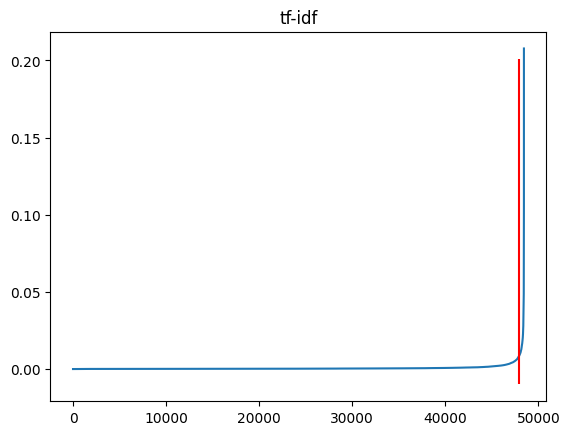

In [8]:
xx = np.sort(tf['tf-idf'].to_numpy())
threshold = np.percentile(tf['tf-idf'].to_numpy(), q=99)

plt.plot(xx);
plt.vlines(x=np.argmax(xx >= threshold), ymin=-0.01, ymax=0.201, color='red');
plt.title('tf-idf');
plt.show();

Посмотрим на эти слова

In [9]:
tf.sort_values('tf-idf', ascending=False).groupby(by='category').first()

,tag,tf-idf
category,,
Автотовары,стартер,0.040078
Аксессуары,капор,0.033475
Бытовая техника,увлажнитель,0.060849
Детям,комбинезон,0.033703
Для ремонта,бетона,0.025391
Дом,тюль,0.020540
Женщинам,оверсайз,0.045051
Здоровье,гребенчатый,0.024752
Зоотовары,кошек,0.083840


In [10]:
kwords = tf.loc[tf['tf-idf'] >= threshold]['tag'].to_list()
len(kwords)

485

In [11]:
X = data_df['name'].to_numpy()
Y = data_df['category'].to_numpy()

Чтоб не перебирать все слова, выберем частые по tf-idf

## Create model

In [12]:
from hoko.models import DecisionTextTree

In [13]:
# Для примера ограничим глубину

model = DecisionTextTree(kwords_list=kwords, depth=2)

In [14]:
%%time
# Обучаем
model.fit(X, Y)

CPU times: user 25.2 s, sys: 4.61 ms, total: 25.2 s
Wall time: 25.3 s


In [15]:
# замеряем точность на тестовой выборке

Y_pred = model.predict(X)
print(f'accuracy score: {(Y_pred == Y).sum() / Y.shape[0]}')

accuracy score: 0.1462200986061233


In [16]:
print("(case")
for sql_cond in model.compile():
    print(f"   {sql_cond}")
print("end) as {{ target }}")

(case
   when 1=1 and {{ feature }} like '%женский%' and {{ feature }} like '%авто%' then 'Аксессуары'
   when 1=1 and {{ feature }} like '%женский%' and {{ feature }} not like '%авто%' then 'Женщинам'
   when 1=1 and {{ feature }} not like '%женский%' and {{ feature }} like '%женская%' then 'Женщинам'
   when 1=1 and {{ feature }} not like '%женский%' and {{ feature }} not like '%женская%' then 'Мужчинам'
end) as {{ target }}
